In [39]:
import torch
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.auto import trange
import numpy as np
import matplotlib.pyplot as plt
from dgl.dataloading import GraphDataLoader
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer
import pandas as pd
import dgl

from gnncloudmanufacturing.data import read_fatahi_dataset, sample_dataset
from gnncloudmanufacturing.mip_solver import mip_solve
from gnncloudmanufacturing.validation import total_cost_from_graph, total_cost_from_gamma, check_feasibility
from gnncloudmanufacturing.utils import (
    GraphDataset, delta_from_gamma, graph_from_problem, gamma_from_target, os_type, ss_type, so_type)
from gnncloudmanufacturing.graph_model import GNN

In [52]:
dataset = sample_dataset(100, [5, 5], [10, 10], [10, 10], 
                         dirpath='../data/', random_seed=0)
len(dataset)

100

In [57]:
train_dataset = dataset[:80]
val_dataset = dataset[80:]

In [58]:
for problem in train_dataset:
    name = problem['name']
    delta = np.load(f'train_data/optimal/{name}/delta.npy')
    gamma = np.load(f'train_data/optimal/{name}/gamma.npy')
    check_feasibility(gamma, delta, problem)
    total_cost = total_cost_from_gamma(problem, gamma, delta)
    print(f'Problem {problem["name"]}: {total_cost:.2f}')

Problem 5,10,10-1: 6298.97
Problem 5,10,10-2: 3627.41
Problem 5,10,10-3: 6958.43
Problem 5,10,10-4: 4703.77
Problem 5,10,10-5: 3865.78
Problem 5,10,10-6: 5347.56
Problem 5,10,10-7: 3625.96
Problem 5,10,10-8: 5546.06
Problem 5,10,10-9: 4167.13
Problem 5,10,10-10: 4763.55
Problem 5,10,10-11: 4668.75
Problem 5,10,10-12: 5848.20
Problem 5,10,10-13: 4728.70
Problem 5,10,10-14: 4205.88
Problem 5,10,10-15: 3611.25
Problem 5,10,10-16: 3879.32
Problem 5,10,10-17: 4470.47
Problem 5,10,10-18: 5015.73
Problem 5,10,10-19: 3942.27
Problem 5,10,10-20: 5072.10
Problem 5,10,10-21: 4616.51
Problem 5,10,10-22: 4903.53
Problem 5,10,10-23: 4995.53
Problem 5,10,10-24: 4964.92
Problem 5,10,10-25: 5219.04
Problem 5,10,10-26: 5580.26
Problem 5,10,10-27: 6272.16
Problem 5,10,10-28: 6265.17
Problem 5,10,10-29: 3127.17
Problem 5,10,10-30: 5683.39
Problem 5,10,10-31: 5906.63
Problem 5,10,10-32: 5086.61
Problem 5,10,10-33: 5217.80
Problem 5,10,10-34: 5047.63
Problem 5,10,10-35: 4020.72
Problem 5,10,10-36: 5609.08
P

In [59]:
average_cost = 0
for problem in val_dataset:
    name = problem['name']
    delta = np.load(f'train_data/optimal/{name}/delta.npy')
    gamma = np.load(f'train_data/optimal/{name}/gamma.npy')
    check_feasibility(gamma, delta, problem)
    total_cost = total_cost_from_gamma(problem, gamma, delta)
    average_cost += total_cost
    print(f'Problem {problem["name"]}: {total_cost:.2f}')
average_cost = average_cost / len(val_dataset)
print(f'Average cost: {average_cost:.2f}')

Problem 5,10,10-81: 4186.93
Problem 5,10,10-82: 4886.04
Problem 5,10,10-83: 5843.99
Problem 5,10,10-84: 4558.87
Problem 5,10,10-85: 5284.90
Problem 5,10,10-86: 5012.60
Problem 5,10,10-87: 4830.58
Problem 5,10,10-88: 4067.46
Problem 5,10,10-89: 3433.57
Problem 5,10,10-90: 6343.88
Problem 5,10,10-91: 4966.50
Problem 5,10,10-92: 4638.07
Problem 5,10,10-93: 5215.45
Problem 5,10,10-94: 3207.28
Problem 5,10,10-95: 4582.09
Problem 5,10,10-96: 4955.25
Problem 5,10,10-97: 3468.02
Problem 5,10,10-98: 5415.36
Problem 5,10,10-99: 4444.16
Problem 5,10,10-100: 3745.12
Average cost: 4654.31


In [62]:
max_operations = 20

train_graphs = []
for problem in train_dataset:
    name = problem['name']
    gamma = np.load(f'train_data/optimal/{name}/gamma.npy')
    graph = graph_from_problem(problem, gamma, max_operations=max_operations)
    graph.edata['feat'][os_type][:, 0] /= 10
    graph.edata['feat'][ss_type][:] /= 100
    train_graphs.append(graph)

val_graphs = []
for problem in val_dataset:
    name = problem['name']
    gamma = np.load(f'train_data/optimal/{name}/gamma.npy')
    graph = graph_from_problem(problem, gamma, max_operations=max_operations)
    graph.edata['feat'][os_type][:, 0] /= 10
    graph.edata['feat'][ss_type][:] /= 100
    val_graphs.append(graph)

In [63]:
train_graph_dataset = GraphDataset(train_graphs)
val_graph_dataset = GraphDataset(val_graphs)

In [64]:
train_dataloader = GraphDataLoader(train_graph_dataset, batch_size=8, shuffle=True)
val_dataloader = GraphDataLoader(val_graph_dataset, batch_size=100)

In [65]:
model = GNN(
    ins_dim=1,
    ino_dim=max_operations,
    out_dim=16,
    n_layers=2,
    lr=0.002,
)
model

GNN(
  (convs): ModuleList(
    (0): AttnConvLayer(
      (W_s): Linear(in_features=1, out_features=16, bias=True)
      (W_os): Linear(in_features=22, out_features=16, bias=True)
      (W_ss): Linear(in_features=2, out_features=16, bias=True)
      (attn): Linear(in_features=32, out_features=1, bias=True)
      (W_in): Linear(in_features=20, out_features=16, bias=True)
      (W_self): Linear(in_features=20, out_features=16, bias=True)
      (W_out): Linear(in_features=20, out_features=16, bias=True)
      (W_o): Linear(in_features=48, out_features=16, bias=True)
    )
    (1): AttnConvLayer(
      (W_s): Linear(in_features=16, out_features=16, bias=True)
      (W_os): Linear(in_features=18, out_features=16, bias=True)
      (W_ss): Linear(in_features=17, out_features=16, bias=True)
      (attn): Linear(in_features=32, out_features=1, bias=True)
      (W_in): Linear(in_features=16, out_features=16, bias=True)
      (W_self): Linear(in_features=16, out_features=16, bias=True)
      (W_o

In [66]:
trainer = Trainer(
    enable_progress_bar=True,
    max_epochs=500,
    log_every_n_steps=1,
    logger=CSVLogger('.'),
    accelerator='cpu',
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/vitaliypozdnyakov/miniconda3/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [67]:
trainer.fit(
    model=model, 
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | convs   | ModuleList        | 4.8 K  | train
1 | dropout | Dropout           | 0      | train
2 | dec     | DotProductDecoder | 0      | train
------------------------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.019     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                   | 0/? [00…

/Users/vitaliypozdnyakov/miniconda3/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/vitaliypozdnyakov/miniconda3/envs/gnn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                          | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

Validation: |                                                                                        | 0/? [00…

`Trainer.fit` stopped: `max_epochs=500` reached.


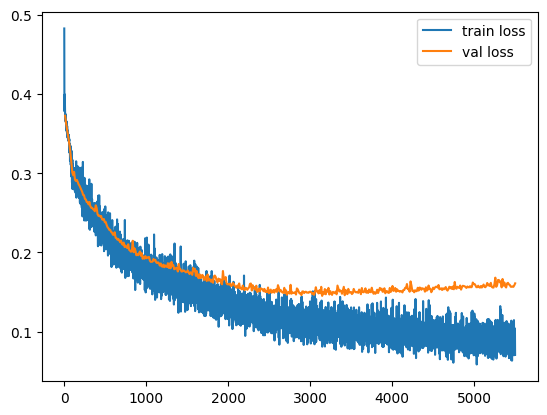

In [68]:
metrics = pd.read_csv(f'lightning_logs/version_{trainer.logger.version}/metrics.csv')
plt.plot(metrics.train_loss.dropna(), label='train loss')
plt.plot(metrics.val_loss.dropna(), label='val loss')
plt.legend()
plt.show()

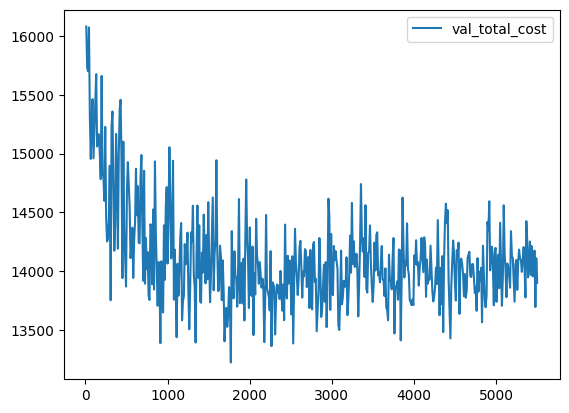

In [69]:
plt.plot(metrics.val_total_cost.dropna(), label='val_total_cost')
plt.legend()
plt.show()